In [21]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, Lasso
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate


Load the data and divide it into training and test data

In [39]:
data_read = pd.read_csv('traindata.csv')
data = data_read.drop(['id','price','date','grade', 'sqft_living15', 'sqft_lot15'], axis=1)
X_train_log = data.drop(['log price'], axis=1)
y_train_log = data['log price']

data_price = data_read.drop(['id','log price','date','grade', 'sqft_living15', 'sqft_lot15'], axis=1)
X_train_price = data_price.drop(['price'], axis=1)
y_train_price = data_price['price']


X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_train_log, y_train_log, test_size=0.2, random_state=42)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_train_price, y_train_price, test_size=0.2, random_state=42)

# Model selection
### Comparing some basic models

Fit the data to Ridge regression and measure the model's performence. We predict both price and log price to see if we should use log price or price as our predictor. We can compare the model by looking at the residuals and the R^2 score

In [47]:
def run_ridge(x_train_ridge, y_train_ridge, x_test_ridge, y_test_ridge):
    """ ridge = Ridge(alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 1])
    ridge.fit(x_train_ridge, y_train_ridge)
    alpha = ridge.alpha_
    new_alphas = [x*alpha for x in [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45]] """
    ridge_best = Ridge()
    ridge_best.fit(x_train_ridge, y_train_ridge)
    """ alpha_best = ridge_best.alpha_ """
    y_pred_train = ridge_best.predict(x_train_ridge)
    y_pred = ridge_best.predict(x_test_ridge)
    rmse = np.sqrt(mean_squared_error(y_test_ridge, y_pred))
    r2 = r2_score(y_test_ridge, y_pred)
    print("Test RMSE: ", rmse)
    print("Train RMSE: ", np.sqrt(mean_squared_error(y_train_ridge, y_pred_train)))
    """ print("Best alpha: ", alpha_best) """
    print("R^2 score:", r2)
    rmse
    residuals = y_test_ridge - y_pred
    plt.scatter(y_test_ridge, residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Actual Price')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()
    return r2, rmse



---- PRICE ----
Test RMSE:  170352.62566027063
Train RMSE:  176513.87478514653
R^2 score: 0.7043317681495889


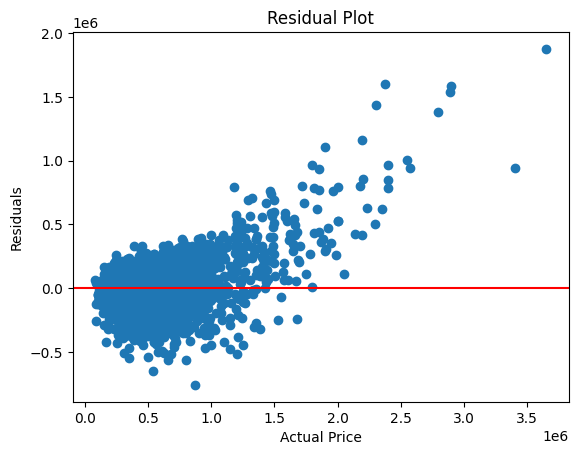

---- LOG PRICE ----
Test RMSE:  0.26122128315658394
Train RMSE:  0.25852180437915456
R^2 score: 0.7353650708651182


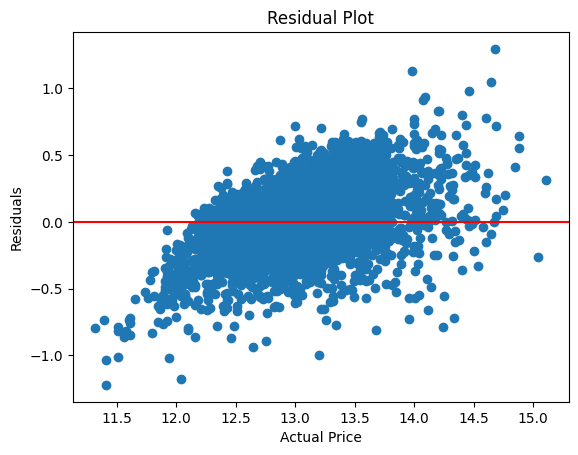

In [48]:
print("---- PRICE ----")
r2_ridge_price, rmse_ridge_price = run_ridge(X_train_price, y_train_price, X_test_price, y_test_price)
print("---- LOG PRICE ----")
r2_ridge_log, rmse_ridge_log = run_ridge(X_train_log, y_train_log, X_test_log, y_test_log)

Seems like log transform of the price is overall a better predictor variable based on the R^2 score and residuals

In [49]:
r2_ridge = r2_ridge_log
rmse_ridge = rmse_ridge_log

Fit the data to Lasso regression, now we use log price. 

In [43]:
lasso_model = Lasso()
lasso_model.fit(X_train_log, y_train_log)
y_pred = lasso_model.predict(X_test_log)
rmse_lasso = np.sqrt(mean_squared_error(y_test_log, y_pred))
r2_lasso = r2_score(y_test_log, y_pred)
print("R^2 score using best alpha:", r2_lasso)
print('RMSE using best alpha:', rmse_lasso)

R^2 score using best alpha: 0.47971639621574813
RMSE using best alpha: 0.3662731177819555


Fit the data to AdaBoost regression

In [44]:
model = AdaBoostRegressor()
model.fit(X_train_log, y_train_log)
y_pred = model.predict(X_test_log)
rmse_adaboost = np.sqrt(mean_squared_error(y_test_log, y_pred))
print("Mean Squared Error: ", rmse_adaboost)
r2_ada = r2_score(y_test_log, y_pred)
print("R^2 score using best alpha:", r2_ada)

Mean Squared Error:  0.260382173917843
R^2 score using best alpha: 0.737062489685425


Fit the data to Gradient boosting regression

In [45]:
model = GradientBoostingRegressor()
model.fit(X_train_log, y_train_log)
y_pred = model.predict(X_test_log)
rmse_gradient = np.sqrt(mean_squared_error(y_test_log, y_pred))
print("Mean Squared Error: ", rmse_gradient)
r2_grad = r2_score(y_test_log, y_pred)
print("R^2 score using best alpha:", r2_grad)

Mean Squared Error:  0.1937173110594818
R^2 score using best alpha: 0.8544651798911396


Let's compare the scores of the models

In [50]:
rmse_table = [['Ridge regression',rmse_ridge, r2_ridge], ['Lasso regression', rmse_lasso, r2_lasso], ['AdaBoost', rmse_adaboost, r2_ada], ['GradientBoost', rmse_gradient, r2_grad]]
print(tabulate(rmse_table, headers=['Model Name', "RMSE", "R^2"], tablefmt="psql"))

+------------------+----------+----------+
| Model Name       |     RMSE |      R^2 |
|------------------+----------+----------|
| Ridge regression | 0.261221 | 0.735365 |
| Lasso regression | 0.366273 | 0.479716 |
| AdaBoost         | 0.260382 | 0.737062 |
| GradientBoost    | 0.193717 | 0.854465 |
+------------------+----------+----------+


Seems like Gradient boosting is yielding the best results. Let's try to find the best parameters for this model. We use cross validation to select the parameters.

In [51]:
model_params = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [60, 80, 100, 120, 140],
    'learning_rate': [0.4, 0.2, 0.1, 0.05],
    'max_depth': [5, 6, 7, 8, 9, 10]
}

grid_search = GridSearchCV(estimator=model_params, param_grid=param_grid, cv=10)
grid_search.fit(X_train_log, y_train_log)
best_params = [
    ['Learning rate', grid_search.best_params_['learning_rate']],
    ['Max depth', grid_search.best_params_['max_depth']],
    ['n estimators', grid_search.best_params_['n_estimators']]
]
print("Best parameters: ")
print(tabulate(best_params, headers=['Parameter', 'Value'], tablefmt="psql"))

Best parameters: 
+---------------+---------+
| Parameter     |   Value |
|---------------+---------|
| Learning_rate |     0.1 |
| Max depth     |     6   |
| n estimators  |   140   |
+---------------+---------+


Let's see if our model improved with hypermarameterization

In [54]:
grid_search.cv_results_['mean_test_score']
y_pred = grid_search.best_estimator_.predict(X_test_log)
rmse_gradient = np.sqrt(mean_squared_error(y_test_log, y_pred))
r2_grad_cv = r2_score(y_test_log, y_pred)
print("RMSE using best parameters:\t", rmse_gradient)
print("R^2 score using best parameters:\t", r2_grad_cv)

RMSE using best parameters:	 0.17100584862331816
R^2 score using best parameters:	 0.8865898362778658


One can see that GradientBoost is performing even better. Let's look at the feature importances of the best performing estimators with the optimal parameters. 

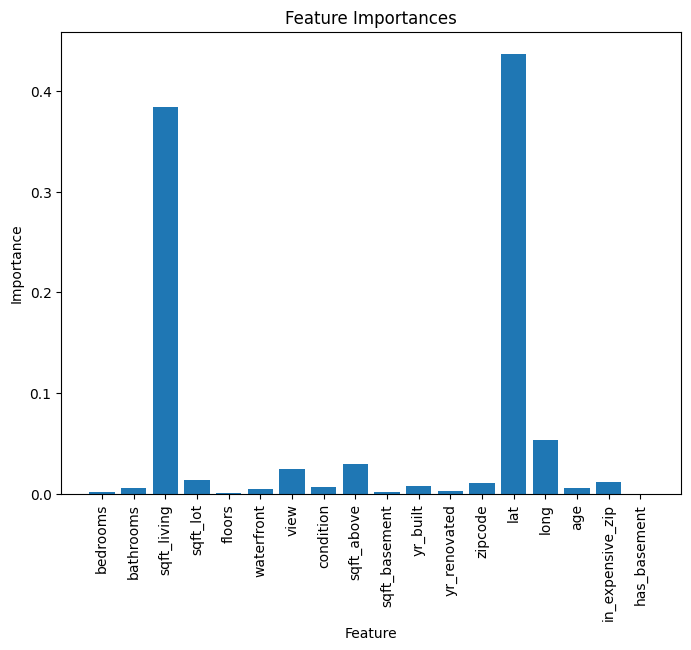

In [55]:
feature_importances  = grid_search.best_estimator_.feature_importances_
feature_names = list(X_train_log.columns)

feature_df = pd.DataFrame()
feature_df['importance'] = feature_importances
feature_df['feature'] = feature_names

plt.figure(figsize=(8, 6))
plt.bar(feature_df['feature'], feature_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

One can see that only a few of the features are significant predictors. Let's train a model by only selecting the top features.

In [56]:
X_train_importance = X_train_log[['bedrooms','bathrooms','sqft_living','view', 'yr_built','yr_renovated','zipcode','lat','long','age', 'in_expensive_zip']]
X_test_importance = X_test_log[['bedrooms','bathrooms','sqft_living','view', 'yr_built','yr_renovated','zipcode','lat','long','age', 'in_expensive_zip']]

grid_search_importance = GridSearchCV(estimator=model_params,
                         param_grid={key: [value] for key, value in grid_search.best_params_.items()}, cv=10)
grid_search_importance.fit(X_train_importance, y_train_log)
best_params = [
    ['Learning rate', grid_search.best_params_['learning_rate']],
    ['Max depth', grid_search.best_params_['max_depth']],
    ['n estimators', grid_search.best_params_['n_estimators']]
]
print("Parameters used on GradBoost after removing features: ")
print(tabulate(best_params, headers=['Parameter', 'Value'], tablefmt="psql"))


Parameters used on GradBoost after removing features: 
+---------------+---------+
| Parameter     |   Value |
|---------------+---------|
| Learning rate |     0.1 |
| Max depth     |     6   |
| n estimators  |   140   |
+---------------+---------+


This model is doing fairly well with the training data only having a limited amount of features. Let's test on the held out test data.

In [57]:
y_pred_importance = grid_search_importance.best_estimator_.predict(X_test_importance)
rmse_gradient_importance = np.sqrt(mean_squared_error(y_test_log, y_pred_importance))
r2_grad_cv_best = r2_score(y_test_log, y_pred_importance)
print("RMSE using best parameters:\t", rmse_gradient_importance)
print("R^2 score using best parameters:\t", r2_grad_cv_best)

RMSE using best parameters:	 0.1797140087003756
R^2 score using best parameters:	 0.8747453341893814


# Predicting house prices

We want apply our trained model to current house prices, to predict if a house for sale is a good buy or a bad buy, essentially predicting it's market value. Our model is trained based on data from 2014 and 2015 and will make wrong predictions, we need to look at the increase in the median house value in each zip in order to adjust our predictions.

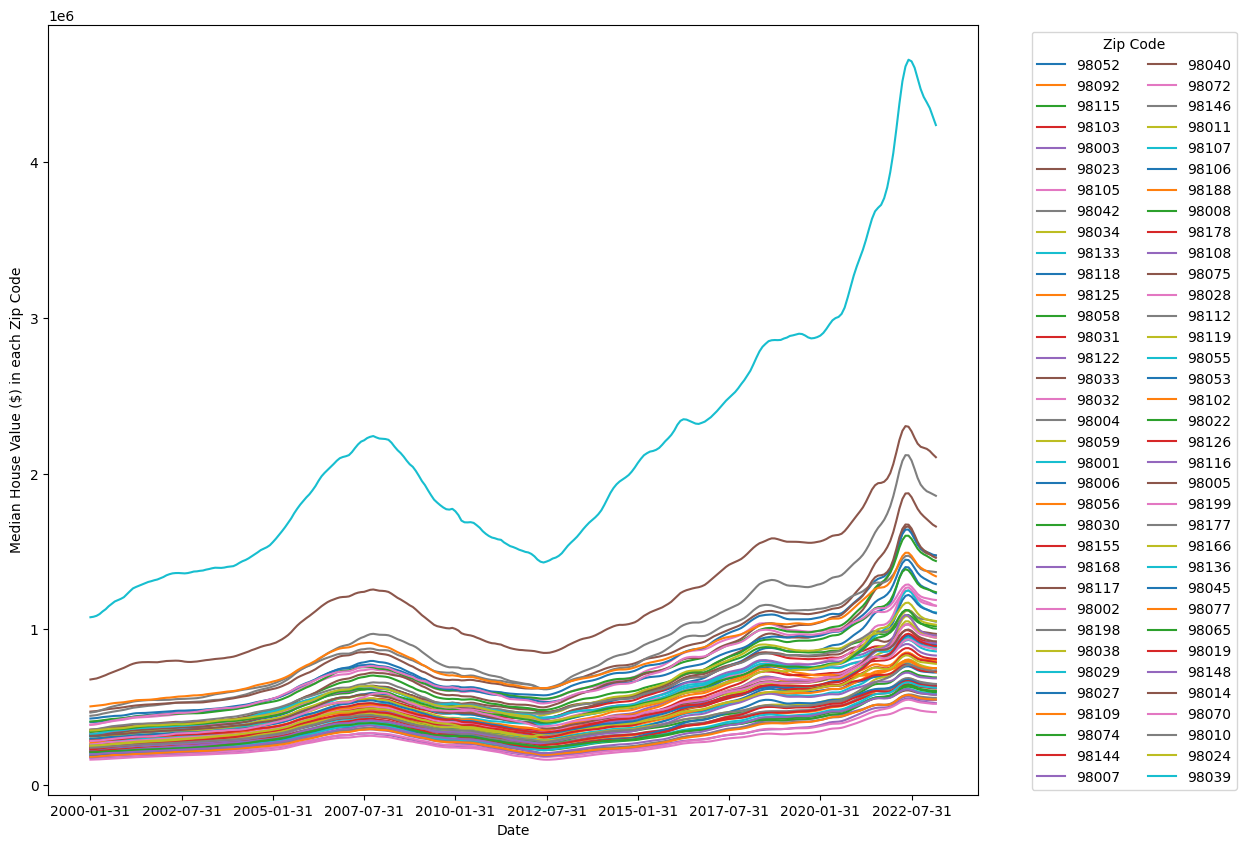

In [286]:
from matplotlib.ticker import MaxNLocator

king_zip = pd.read_csv("king_county_zip.csv")
zip_codes = king_zip["RegionName"].unique()

fig, ax = plt.subplots(figsize=(12, 10))
for zip_code in zip_codes:
    subset = king_zip[king_zip["RegionName"] == zip_code]
    ax.plot(subset.columns[2:], subset.iloc[:, 2:].values.flatten(), label=zip_code)
ax.legend(title="Zip Code", loc="upper left", bbox_to_anchor=(1.05, 1), ncol=2)
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(MaxNLocator(nbins=12, prune='both'))
ax.set_ylabel("Median House Value ($) in each Zip Code")
plt.show()

zip_diff_dict = {}
start_date = '2015-01-31'
end_date = '2023-03-31'

for zip_code in zip_codes:
    row = king_zip.loc[king_zip['RegionName'] == zip_code]
    first_price = row.iloc[0]['2015-01-31']
    last_price = row.iloc[0]['2023-03-31']
    price_diff = last_price/first_price
    zip_diff_dict[zip_code] = price_diff


**Predicting housing prices based on information from zwillow**

In this part, we are looking for houses within zipcodes that our dataset includes. Then we find information about the house, add these values to a dataframe and use our model to predict the price of the house based on the information we have collected. 

**Prediction on house from Zillow**

We found a house for sale on Zillow which was previously sold in the time interval the training data was collected

- https://www.zillow.com/homedetails/18399-NE-97th-Ct-Redmond-WA-98052/48741128_zpid/
- 1650
- Bedrooms: 3
- Bathrooms: 3 (2.5)
- Zipcode: 98052
- Does not have view towards lake
- latitude: 47.6863	
- longitude: -122.093
- age: 18
- not in expensive neighborhood

In [70]:
zip_code = 98052
target_house = X_train_importance.loc[6274]
target_actual_price = round(np.exp(y_train_log[6274]))
predicted_2014 = grid_search_importance.best_estimator_.predict(target_house)
print("Actual price:", target_actual_price)
print("Predicted price:", predicted_2014)

bedrooms                3.0000
bathrooms               2.5000
sqft_living          1650.0000
view                    0.0000
yr_built             1996.0000
yr_renovated            0.0000
zipcode             98052.0000
lat                    47.6863
long                 -122.0930
age                    18.0000
in_expensive_zip        0.0000
Name: 6274, dtype: float64

472500

In [297]:
predicted_prices = []

**House 1**

- https://www.zillow.com/homedetails/15538-NE-15th-Pl-301-Bellevue-WA-98007/2065445877_zpid/
- Price: $1,399,995
- 1 719 sqft
- Bedrooms: 3
- Bathrooms: 3
- zipcode: 98007
- Does not have view towards lake
- Grade : 8
- latitude: 47.623370
- longitude: -122.333330
- age: 0
- not in expensive neighborhood

In [298]:
data_zwillow = {'bedrooms':[3], 'bathrooms':[3], 'sqft_living': [1719],'view':[0], 
                 'yr_built':[2023],'yr_renovated':[2023],'zipcode':[98007],'lat': [47.623370], 'long': [-122.133130], 'age': [0], 'in_expensive_zip': [0]}
zip_code = 98007

zwillow_house = pd.DataFrame(data_zwillow)

log_price = grid_search_importance.best_estimator_.predict(zwillow_house)
price = np.exp(log_price)
multiplier = zip_diff_dict[zip_code]
predicted_price = round(price[0]*multiplier)
predicted_prices.append(predicted_price)

print("Predicted price: ", predicted_price)
print("Difference from original price: ", 1399995-predicted_price)
print("Missing by: ", (1399995-predicted_price)/1399995*100, "%")

Predicted price:  1567861
Difference from original price:  -167866
Missing by:  -11.990471394540695 %


**House 2**

- https://www.zillow.com/homes/13813-139th-Ave-SE-Renton,-WA-98059_rb/48856621_zpid/
- Price: $785000
- 2 120 sqft
- Bedrooms : 4
- Bathrooms : 2
- zipcode: 98959
- Does not have view towards lak
- latitude: 47.6105643
- longitude: -122.1525164
- age: 50
- not in expensive neighborhood

In [299]:
data_zwillow2 = {'bedrooms':[4], 'bathrooms':[2], 'sqft_living': [2120],'view':[0], 
                  'yr_built':[1967],'yr_renovated':[2016],'zipcode':[98059],'lat': [47.4789055], 'long': [-122.1545805], 'age': [56], 'in_expensive_zip': [0]}
zwillow_house2 = pd.DataFrame(data_zwillow2)

zip_code = 98059
log_price2 = grid_search_importance.best_estimator_.predict(zwillow_house2)
price2 = np.exp(log_price2)
multiplier = zip_diff_dict[zip_code]
predicted_price = round(price2[0]*multiplier)
predicted_prices.append(predicted_price)

print("Predicted price: ", predicted_price)
print("Difference from original price: ", 758000-predicted_price)
print("Missing by: ", (predicted_price-758000)/758000*100, "%")

Predicted price:  758004
Difference from original price:  -4
Missing by:  0.0005277044854881266 %


**House 3**

- https://www.zillow.com/homedetails/4053-S-151st-St-Tukwila-WA-98188/48650781_zpid/
- Price: $1,139,000
- 1390 sqft
- Does not have view towards lake
- Grade : 7
- latitude: 47.6105643
- longitude: -122.1525164
- age: 50
- not in expensive neighborhood

In [300]:
data_zwillow3 = {'bedrooms':[3], 'bathrooms':[2], 'sqft_living': [1390],'view':[0], 
                  'yr_built':[1993],'yr_renovated':[0],'zipcode':[98188],'lat': [47.467670], 'long': [-122.282220], 'age': [30], 'in_expensive_zip': [0]}
zwillow_house3 = pd.DataFrame(data_zwillow3)

zip_code = 98188
log_price3 = grid_search_importance.best_estimator_.predict(zwillow_house3)
price3 = np.exp(log_price3)
multiplier = zip_diff_dict[zip_code]
predicted_price = round(price3[0]*multiplier)
predicted_prices.append(predicted_price)

print("Predicted price: ", predicted_price)
print("Difference from original price: ", 549000-predicted_price)
print("Missing by: ", (predicted_price-549000)/549000*100, "%")

Predicted price:  554882
Difference from original price:  -5882
Missing by:  1.0714025500910747 %


**House 4**

- https://www.zillow.com/homedetails/3720-S-Pilgrim-St-Seattle-WA-98118/49082330_zpid/
- Price: 420,000$
- 994 sqft
- Bedrooms: 2
- Bathrooms: 1
- Does not have view towards lake
- latitude: 47.6105643
- longitude: -122.1525164
- age: 50
- not in expensive neighborhood

In [301]:
data_zwillow4 = {'bedrooms':[3], 'bathrooms':[3], 'sqft_living': [2020],'view':[0], 
                  'yr_built':[1919],'yr_renovated':[1993],'zipcode':[98118],'lat': [47.5159181], 'long': [-122.2850992], 'age': [30], 'in_expensive_zip': [0]}
zwillow_house4 = pd.DataFrame(data_zwillow4)

zip_code = 98118
log_price4 = grid_search_importance.best_estimator_.predict(zwillow_house4)
price4 = np.exp(log_price4)
multiplier = zip_diff_dict[zip_code]
predicted_price = round(price4[0]*multiplier)
predicted_prices.append(predicted_price)

print("Predicted price:", predicted_price)
print("Difference from original price:", 635000-predicted_price)
print("Missing by:",(635000- predicted_price)/635000*100, "%")

Predicted price: 698993
Difference from original price: -63993
Missing by: -10.07763779527559 %


**House 5**

- https://www.zillow.com/homedetails/13027-40th-Ave-S-Tukwila-WA-98168/48766670_zpid/
- Price: $550,000 (Was $465,000 in march!)
- 994 sqft
- Bedrooms: 4
- Bathrooms: 2
- Does not have view towards lake
- latitude: 47.48646
- longitude: -122.28388
- age: 103
- not in expensive neighborhood

In [302]:
data_zwillow5 = {'bedrooms':[4], 'bathrooms':[2], 'sqft_living': [1600],'view':[0], 
                  'yr_built':[1920],'yr_renovated':[2017],'zipcode':[98168],'lat': [47.486460], 'long': [-122.283880], 'age': [103], 'in_expensive_zip': [0]}
zwillow_house5 = pd.DataFrame(data_zwillow5)

zip_code = 98168
log_price5 = grid_search_importance.best_estimator_.predict(zwillow_house5)
price5 = np.exp(log_price5)
multiplier = zip_diff_dict[zip_code]
predicted_price = round(price5[0]*multiplier)
predicted_prices.append(predicted_price)

print("Predicted price:", predicted_price)
print("Difference from original price:", 550000-predicted_price)
print("Missing by:",(550000- predicted_price)/550000*100, "%")

Predicted price: 439022
Difference from original price: 110978
Missing by: 20.177818181818182 %


**House 6**

- https://www.zillow.com/homedetails/4030-S-213th-Ct-UNIT-C-Seattle-WA-98198/83227354_zpid/
- Price: $429,000
- 1149 sqft
- Bedrooms: 2
- Bathrooms: 2
- Does not have view towards lake
- latitude: 47.41045
- longitude: -122.28487
- age: 17
- not in expensive neighborhood

In [303]:
data_zwillow6 = {'bedrooms':[2], 'bathrooms':[2], 'sqft_living': [1149],'view':[0], 
                  'yr_built':[2006],'yr_renovated':[0],'zipcode':[98198],'lat': [47.41045], 'long': [-122.28487], 'age': [17], 'in_expensive_zip': [0]}
zwillow_house6 = pd.DataFrame(data_zwillow6)

zip_code = 98198
log_price6 = grid_search_importance.best_estimator_.predict(zwillow_house6)
price6 = np.exp(log_price6)
multiplier = zip_diff_dict[zip_code]
predicted_price = round(price6[0]*multiplier)
predicted_prices.append(predicted_price)

print("Predicted price:", predicted_price)
print("Difference from original price:", 429000-predicted_price)
print("Missing by:",(429000 - predicted_price)/429000*100, "%")


Predicted price: 474080
Difference from original price: -45080
Missing by: -10.508158508158507 %


**House 7**

- https://www.zillow.com/homedetails/15212-37th-Pl-S-Tukwila-WA-98188/48650908_zpid/
- Price: $555,000  
- 2020 sqft
- Bedrooms: 3
- Bathrooms: 2
- Does not have view towards lake
- latitude: 47.46635
- longitude: -122.28483
- age: 83
- not in expensive neighborhood

In [304]:
data_zwillow7 = {'bedrooms':[3], 'bathrooms':[2], 'sqft_living': [2020],'view':[0], 
                  'yr_built':[1940],'yr_renovated':[2023],'zipcode':[98188],'lat': [47.46635], 'long': [-122.28483], 'age': [83], 'in_expensive_zip': [0]}
zwillow_house7 = pd.DataFrame(data_zwillow7)

zip_code = 98188
log_price7 = grid_search_importance.best_estimator_.predict(zwillow_house7)
price7 = np.exp(log_price7)
multiplier = zip_diff_dict[zip_code]
predicted_price = round(price7[0]*multiplier)
predicted_prices.append(predicted_price)

print("Predicted price:", predicted_price)
print("Difference from original price:", 555000-predicted_price)
print("Missing by:",(555000 - predicted_price)/555000*100, "%")


Predicted price: 594356
Difference from original price: -39356
Missing by: -7.091171171171171 %


**All houses**

How does our model perform when trying to predict the houses? Let's see.

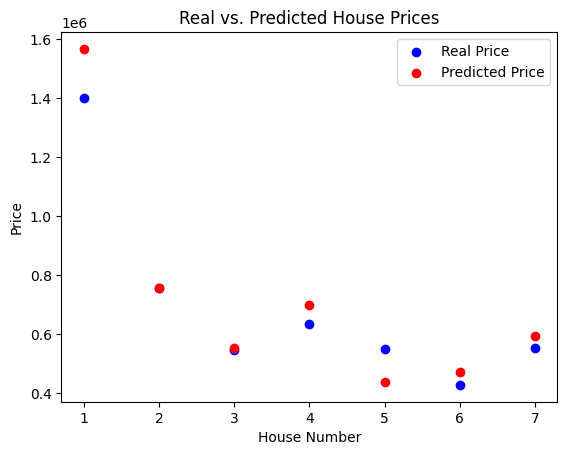

In [305]:
real_prices = [1399995, 758000, 549000, 635000, 550000, 429000, 555000]
houses = range(1, len(real_prices)+1)
plt.scatter(houses, real_prices, color='blue', label='Real Price')
plt.scatter(houses, predicted_prices, color='red', label='Predicted Price')
plt.xlabel('House Number')
plt.ylabel('Price')
plt.title('Real vs. Predicted House Prices')
plt.legend()
